In [28]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [29]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])
df_tea = df.loc[df['Product']=='Tea',['Date','Quantity']].reset_index(drop=True)
del df

split_date = '2023-05-31'

df_train = df_tea[df_tea['Date']<=split_date].copy()

In [30]:
scaler_t = StandardScaler()

df_tea_bc_scaled = df_train.copy()

df_tea_bc_scaled['Quantity_BC_Transform'], lam = boxcox(df_tea_bc_scaled['Quantity'])
df_tea_bc_scaled['Quantity_BC_Scaled'] = scaler_t.fit_transform(df_tea_bc_scaled[['Quantity_BC_Transform']])
df_tea_bc_scaled['Difference'] = df_tea_bc_scaled['Quantity_BC_Scaled'].diff()

In [32]:
idx = 8

model_df = df_tea_bc_scaled.copy()
time_lag(model_df,'Difference',steps=idx)
model_df = model_df.dropna()

target = model_df['Difference']

f = []
for i in range(1,idx+1):
    f.append(f't-{i}')

features = model_df[f]

features = sm.add_constant(features)

bc_scaled_mlr_model = sm.OLS(target,features).fit()

bc_scaled_mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     11.26
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           4.34e-12
Time:                        09:46:20   Log-Likelihood:                -97.811
No. Observations:                 142   AIC:                             213.6
Df Residuals:                     133   BIC:                             240.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0633      0.043      1.479      0.142      -0.021       0.148
t-1           -0.6630      0.086     -7.681      0.000      -0.834      -0.492
t-2           -0.4441      0.102     -4.337      0.000      -0.647      -0.242
t-3           -0.2533      0.107     -2.369      0.019      -0.465      -0.042
t-4           -0.5406      0.103     -5.230      0.000      -0.745      -0.336
t-5           -0.4337      0.104     -4.186      0.000      -0.639      -0.229
t-6           -0.2965      0.108     -2.750      0.007      -0.510      -0.083
t-7           -0.1883      0.104     -1.812      0.072      -0.394       0.017
t-8           -0.0978      0.087     -1.126      0.262      -0.270       0.074
==============================================================================
Omnibus:                        4.843   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.335
Skew:                          -0.400   Prob(JB):                        0.114
Kurtosis:                       3.306   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

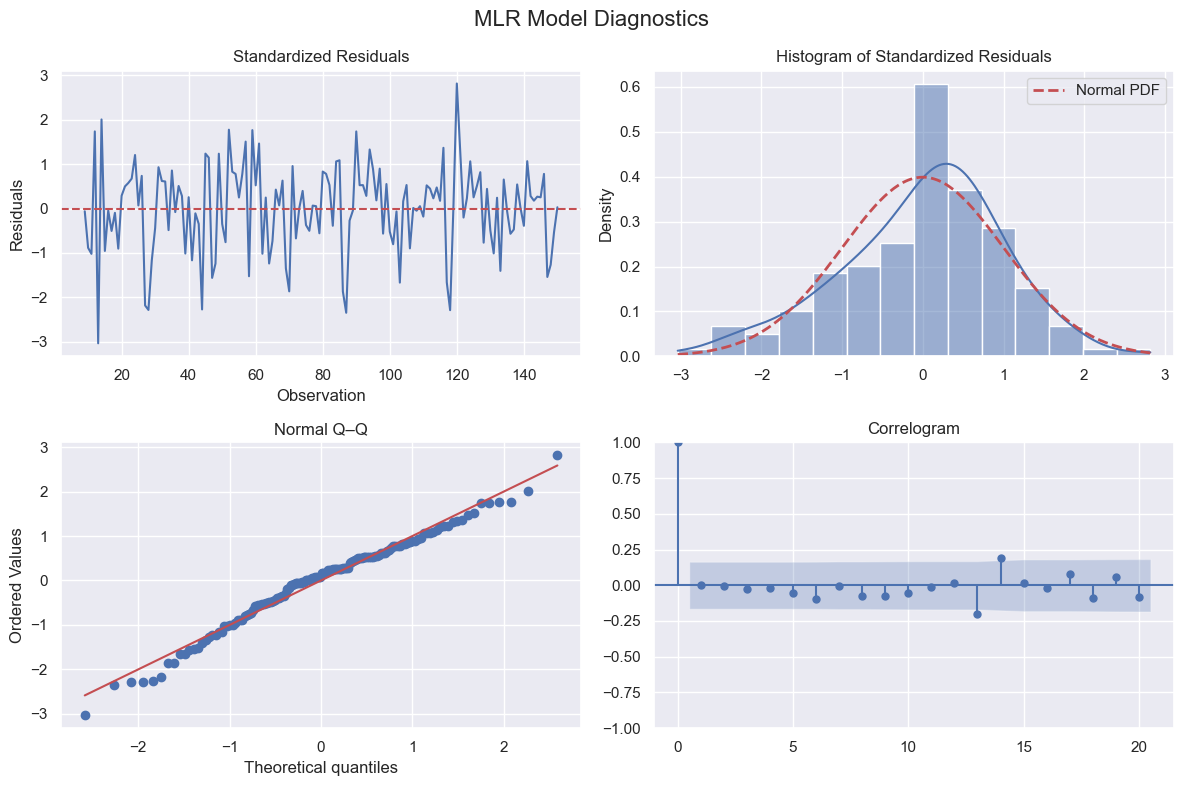

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("MLR Model Diagnostics", fontsize=16)

residuals = bc_scaled_mlr_model.resid
resid_std = (residuals - residuals.mean()) / residuals.std()

#Residuals
axes[0, 0].plot(resid_std, linestyle='-')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Standardized Residuals")
axes[0, 0].set_xlabel("Observation")
axes[0, 0].set_ylabel("Residuals")

#Histogram
sns.histplot(resid_std, kde=True, stat="density", ax=axes[0, 1])

x = np.linspace(resid_std.min(), resid_std.max(), 200)
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r--', linewidth=2, label="Normal PDF")
axes[0, 1].legend()
axes[0, 1].set_title("Histogram of Standardized Residuals")

#Q–Q plot
stats.probplot(resid_std, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q–Q")

#ACF plot
plot_acf(resid_std, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("Correlogram")

plt.tight_layout()

plt.savefig('Images/Tea_MLR_Model_Diagnostics.png')

plt.show()

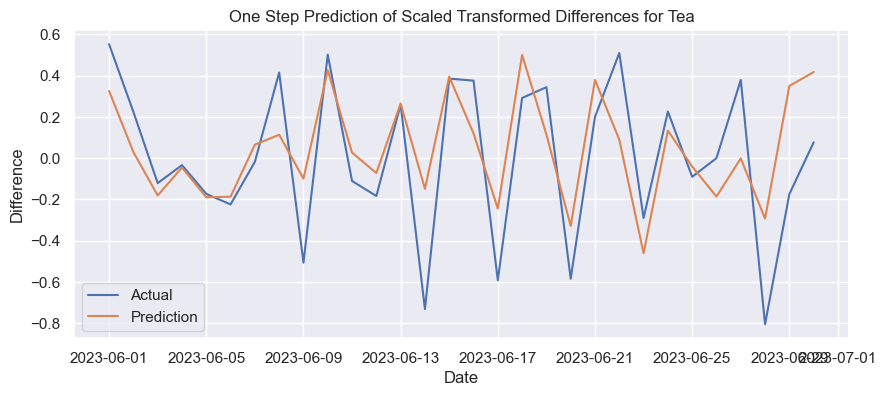

In [51]:
df_test = df_tea.iloc[df_tea.index[df_tea['Date'] == split_date][0]-idx:,].copy()
df_test['Quantity_BC_Transform'] = boxcox(df_test['Quantity'],lam)
df_test['Quantity_BC_Scaled'] = scaler_t.transform(df_test[['Quantity_BC_Transform']])
df_test['Difference'] = df_test['Quantity_BC_Scaled'].diff()

time_lag(df_test,'Difference',steps=idx)

df_test = df_test.dropna()

predictors = df_test.filter(like='t-')

predictors = sm.add_constant(predictors)

df_test['pred'] = bc_scaled_mlr_model.predict(predictors)

plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test, x='Date', y='Difference',label = 'Actual')
ax = sns.lineplot(data=df_test, x='Date', y='pred', label = 'Prediction')
ax.set(title = "One Step Prediction of Scaled Transformed Differences for Tea")
plt.show()

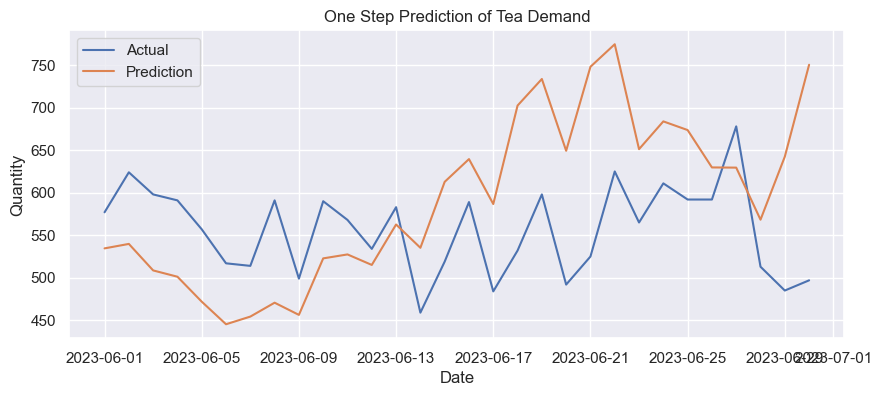

In [54]:
last_value = df_tea_bc_scaled['Quantity_BC_Scaled'][150]

df_test_rollup = df_test[['Date', 'Quantity','Quantity_BC_Scaled','Difference','pred']].copy()

#add the differences starting with the last scaled transformed value (5-31-23) -> df_coffee_bc_scaled['Quantity_BC_Scaled'][150]
df_test_rollup['pred_undifferenced'] = df_test_rollup['pred'].cumsum() + last_value

#undo scaling
df_test_rollup['Undifferenced Unscaled'] = scaler_t.inverse_transform(df_test_rollup[['pred_undifferenced']])

#undo Box-Cox transform
df_test_rollup['Predicted Quantity'] = inv_boxcox(df_test_rollup['Undifferenced Unscaled'], lam)
df_test_rollup = df_test_rollup[['Date','Quantity','Predicted Quantity']]

plt.figure(figsize=(10,4))

ax= sns.lineplot(data=df_test_rollup, x='Date', y='Quantity',label ="Actual")
ax = sns.lineplot(data=df_test_rollup, x='Date', y='Predicted Quantity', label = 'Prediction')
ax.set(title = "One Step Prediction of Tea Demand")
plt.show()

In [41]:
mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_test_rollup['Predicted Quantity'])*100

print(f'One Step Quantity MAPE: {mape:.2f}%')

One Step Quantity MAPE: 17.08%


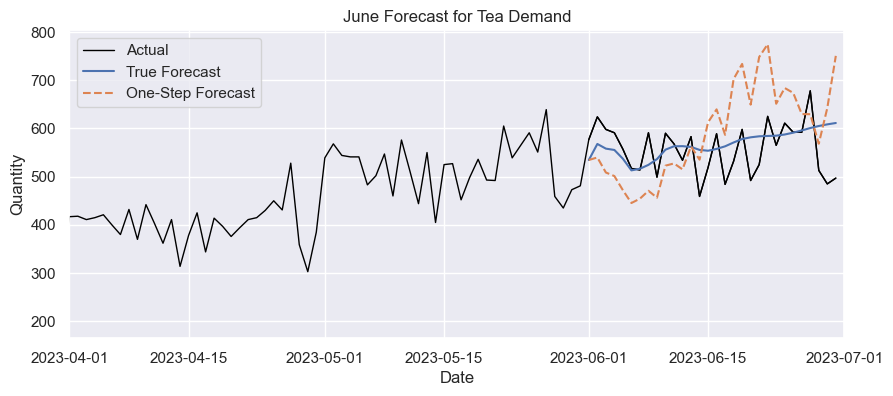

In [53]:
test_dates = pd.date_range('2023-06-01', '2023-06-30', freq='D')

latest_lags = list(df_test.iloc[0][['t-1','t-2','t-3','t-4','t-5','t-6','t-7','t-8']])

lags = [f't-{i}' for i in range(1, 9)]

forecast_diffs = []

for _ in range(len(test_dates)):
    X_new = pd.DataFrame([latest_lags], columns=lags)
    X_new = sm.add_constant(X_new, has_constant='add')
    
    y_pred = bc_scaled_mlr_model.predict(X_new)[0]
    forecast_diffs.append(y_pred)
    
    # Update lag list for next day (push new prediction, drop oldest)
    latest_lags = [y_pred] + latest_lags[:-1]

df_forecast = pd.DataFrame({
    'Date': test_dates,
    'Predicted_Difference': forecast_diffs
})


df_forecast['Re-Summed'] = df_forecast['Predicted_Difference'].cumsum() + last_value

df_forecast['Unscaled'] = scaler_t.inverse_transform(df_forecast[['Re-Summed']])

df_forecast['Predicted Quantity'] = inv_boxcox(df_forecast['Unscaled'],lam)

plt.figure(figsize=(10,4))

ax = sns.lineplot(data=df_tea, x='Date',y='Quantity',c='black', linewidth = 1)
ax= sns.lineplot(data=df_test_rollup, x='Date', y='Quantity',label ="Actual", c = 'black', linewidth = 1)
ax = sns.lineplot(data=df_forecast, x='Date',y='Predicted Quantity',label='True Forecast')
ax = sns.lineplot(data=df_test_rollup, x='Date', y= 'Predicted Quantity', label = 'One-Step Forecast', linestyle = '--')

ax.set(title = "June Forecast for Tea Demand")
plt.xlim(np.datetime64('2023-04-01'),np.datetime64('2023-07-01'))
plt.show()

In [48]:
forecast_mape = mean_absolute_percentage_error(df_test_rollup['Quantity'],df_forecast['Predicted Quantity'])*100

print(f'Final Forecast MAPE: {forecast_mape:.2f}%')

Final Forecast MAPE: 8.34%
